In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import clone

from processing_functions import *

In [2]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('data/input_file.csv')
#nan_percentage(df) 

There is a lot of data missing for how people think others perceive them, and what attributes they think the rest of their sex prefer. 

Since I am also going to be working with no gender, I will drop any column related to the binary separation of gender.

The attribute that overall has the most amount of missing data is 'shared interests'. I was hoping to use this attribute as a reliable feature to find partners, but based on the findings made in the EDA it is the feature that is the least important. 

In [3]:
def drop_columns(df, suffix):
    cols = [col for col in df.columns if any(col.endswith(s) for s in suffix)]
    
    df = df.drop(columns=cols, errors='ignore')
    
    return df
    

suffix= ['_fellow_want', 'perceived', '_o_want', '_diff']
df = drop_columns(df, suffix)
df_final = df.drop(columns=['Unnamed: 0'])
df_pred = df_final.copy(deep=True)

Since there are too many people and waves in this experiment, I am going to opt to drop the rows that have nan values so that it is easier to work with when it comes to training the dataset (especially with Random Forest). 

In [4]:
df_final.head()

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.0,20.0,...,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.0,0.0,...,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
2,1,1.0,1,3,13.0,1,0.16,22.0,19.0,18.0,...,7.0,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN
3,1,1.0,1,4,14.0,1,0.61,23.0,30.0,5.0,...,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.0,10.0,...,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0


In [5]:
df_final = df_final.dropna()
print(df_final.columns)

Index(['iid', 'id', 'wave', 'partner', 'pid', 'match', 'int_corr', 'age_o',
       'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
       'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o',
       'like_o', 'prob_o', 'age', 'imprelig', 'goal', 'date', 'go_out',
       'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking',
       'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts',
       'music', 'shopping', 'yoga', 'exphappy', 'expnum', 'attr_important',
       'sinc_important', 'intel_important', 'fun_important', 'amb_important',
       'shar_important', 'attr_self', 'sinc_self', 'fun_self', 'intel_self',
       'amb_self', 'dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
       'like', 'prob'],
      dtype='object')


In [6]:
# Dropping identifier columns and irrelevant features for prediction
df = df_final.drop(columns=['iid', 'id', 'pid', 'partner', 'wave'], axis=1)

In [7]:
df.head()

,match,int_corr,age_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,0,0.14,27.0,35.0,20.0,20.0,20.0,0.0,5.0,0,...,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,0,0.54,22.0,60.0,0.0,0.0,40.0,0.0,0.0,0,...,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,0.61,23.0,30.0,5.0,15.0,40.0,5.0,5.0,1,...,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,0.21,24.0,30.0,10.0,20.0,10.0,10.0,20.0,1,...,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,0,0.25,25.0,50.0,0.0,30.0,10.0,0.0,10.0,1,...,7.0,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0


In [8]:
X = df.drop(['match', 'dec', 'dec_o'], axis=1)
y = df['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [9]:
# Start by modelling a LightGBM and Random Forest model 
# Will do comparison of both and decide based on 
# maybe can try to use LightGBM but using 'random forest' as the boosting_type(?)

lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

lgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [10]:
rf_accuracy = cross_val_score(rf_model, X_train, y_train, cv=5)
lgb_accuracy = cross_val_score(lgb_model, X_train, y_train, cv=5)
xgb_accuracy = cross_val_score(xgb_model, X_train, y_train, cv=5)

print("Random Forest Accuracy: ", rf_accuracy.mean())
print("LightGBM Accuracy: ", lgb_accuracy.mean())
print("XGBClassifier Accuracy: ", xgb_accuracy.mean())

Random Forest Accuracy:  0.8533333333333333
LightGBM Accuracy:  0.8573333333333333
XGBClassifier Accuracy:  0.844


In [11]:
# Comparison between models with classification_report
# Make prediction on the testing data
y_pred_rf = rf_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Classification Report
print("RandomForestClassifier:\n", classification_report(y_test, y_pred_rf, zero_division=0))
print("LightGBM:\n", classification_report(y_pred_lgb, y_test))
print("XGBClassifer:\n", classification_report(y_pred_xgb, y_test))

print("\n")

# F1 Score
print("RandomForestClassifier F1 score:\n", f1_score(y_test, y_pred_rf, zero_division=0, average="weighted"),"\n")
print("LightGBM F1 score:\n", f1_score(y_pred_lgb, y_test, average="weighted"),"\n")
print("XGBClassifer F1 score:\n", f1_score(y_pred_xgb, y_test, average="weighted"))

RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.88      0.98      0.92       208
           1       0.75      0.35      0.48        43

    accuracy                           0.87       251
   macro avg       0.81      0.66      0.70       251
weighted avg       0.86      0.87      0.85       251

LightGBM:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       213
           1       0.56      0.63      0.59        38

    accuracy                           0.87       251
   macro avg       0.75      0.77      0.76       251
weighted avg       0.88      0.87      0.87       251

XGBClassifer:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       217
           1       0.56      0.71      0.62        34

    accuracy                           0.88       251
   macro avg       0.76      0.81      0.78       251
weighted avg       0.90

In [12]:
df['match'].value_counts(normalize=True)

0    0.800319
1    0.199681
Name: match, dtype: float64

After looking at the accuracy and the other metrics we can see that, same as had previously measured in the EDA, this is a very unbalanced dataset. Almost 80% of the values belong to 0, while only 20% is part of the positive results.

There is a much higher number of 0s (no matches) than 1s (matches), there this makes the precision, accuracy and recall of the matches much more lower than the no matches.

We need to find a weight balance in order to work with it and in return choose the most appropriate model to work with.
References found in: [https://stackoverflow.com/questions/51190809/high-auc-but-bad-predictions-with-imbalanced-data]

We might also want to look into the performance of a =XGBoost= model since it performs better for unbalanced data. 
The boosting algorithm iteratively learns from the mistakes of the previous tree. So if a tree fails to predict a class (most likely the imbalanced class), the proceeding tree will give more weightage to this sample.

In [13]:
def pr_threshold(model, model_name='Model'):
    """
    Calculate and plot the precision-recall curve for a given model and test data.
    Also, find the threshold that yields the highest F1 score using an iterative method and plot the classification report based on this threshold.

    Parameters:
    model: The trained classifier to evaluate.
    X_test: The test features.
    y_test: The true labels for the test set.
    model_name (optional): Name of the model to include in the plot title.

    Returns:
    optimal_threshold: The threshold value that yields the highest F1 score.
    optimal_report: Classification report using the optimal threshold.
    """
    # probabilities for the positive class
    probabilities = model.predict_proba(X_val)[:,1]

    # precision, recall, and thresholds using the predicted probabilities
    precision, recall, thresholds = precision_recall_curve(y_val, probabilities)

    # F1 score for each threshold with tiny constant to avoid division by zero
    fscore = (2 * precision * recall) / (precision + recall + 1e-12)

    # Find the index of the maximum F1 score
    optimal_index = np.argmax(fscore)
    best_threshold = thresholds[optimal_index]

    # Make final predictions using the optimal threshold
    final_predictions = (model.predict_proba(X_test)[:,1] >= best_threshold).astype(int)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
    plt.plot(thresholds, (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12), 'r-.', label='F1 Score')
    plt.axvline(x=best_threshold, color='k', linestyle='--', label='Optimal Threshold')
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.title(f'{model_name}: Precision, Recall, and F1 Score for different thresholds')
    plt.show()

    optimal_report = classification_report(y_test, final_predictions, zero_division=0)
    return best_threshold, optimal_report

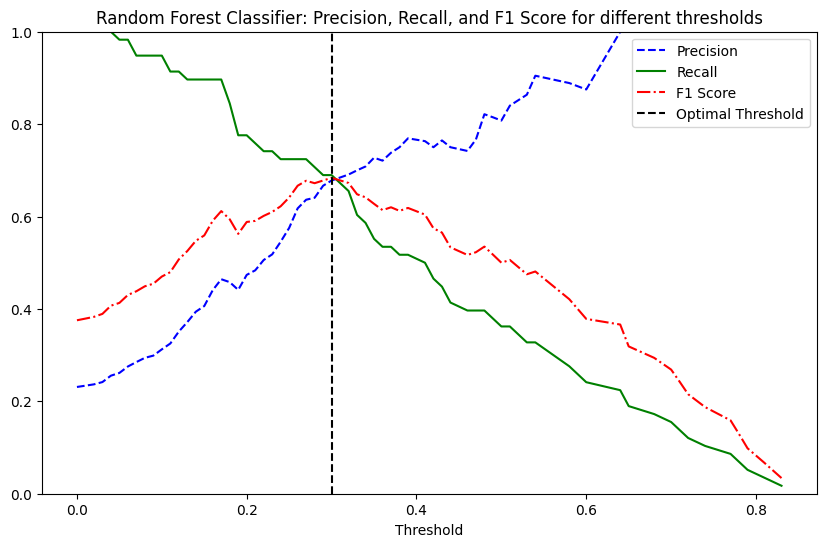

Optimal threshold for maximum Random Forest F1-score: 0.3
Using threshold ~0.3000 for evaluation.

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       208
           1       0.47      0.67      0.55        43

    accuracy                           0.81       251
   macro avg       0.70      0.76      0.72       251
weighted avg       0.85      0.81      0.83       251
 

Random Forest: f1 score 0.8890810551048869


In [14]:
optimal_threshold_rf, optimal_report_rf = pr_threshold(rf_model, model_name='Random Forest Classifier')

print("Optimal threshold for maximum Random Forest F1-score:", optimal_threshold_rf)
print(f"Using threshold ~{optimal_threshold_rf:.4f} for evaluation.\n")
print(optimal_report_rf, "\n")

final_predictions_rf = (rf_model.predict(X_test) >= 0.25).astype(int)
print("Random Forest: f1 score", f1_score(final_predictions_rf, y_test, average="weighted"))

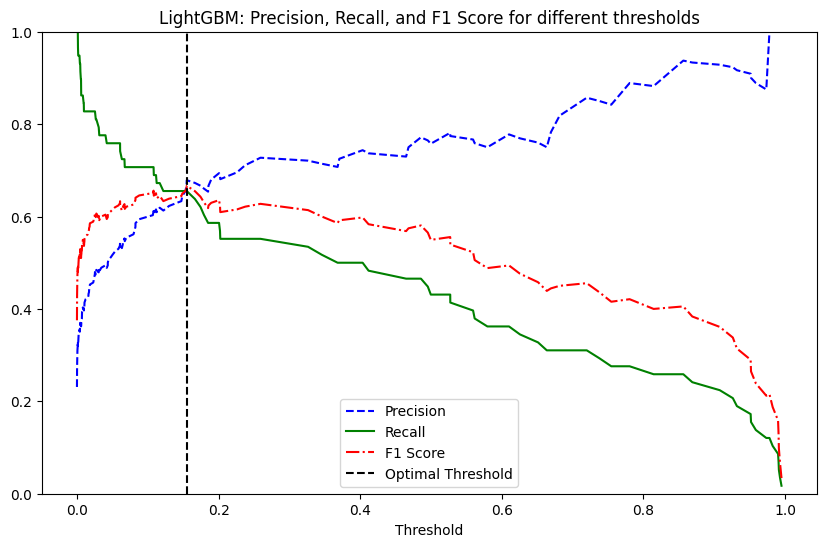

Optimal threshold for maximum LightGBM F1-score: 0.155051421246994
Using threshold ~0.1551 for evaluation.

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       208
           1       0.46      0.63      0.53        43

    accuracy                           0.81       251
   macro avg       0.69      0.74      0.70       251
weighted avg       0.84      0.81      0.82       251

LightGBM: F1 score 0.871803014036929


In [15]:
optimal_threshold_lgb, optimal_report_lgb = pr_threshold(lgb_model, model_name='LightGBM')

print("Optimal threshold for maximum LightGBM F1-score:", optimal_threshold_lgb)
print(f"Using threshold ~{optimal_threshold_lgb:.4f} for evaluation.\n")
print(optimal_report_lgb)

final_predictions_lgb = (lgb_model.predict(X_test) >= optimal_threshold_lgb).astype(int)
print("LightGBM: F1 score", f1_score(final_predictions_lgb, y_test, average="weighted"))

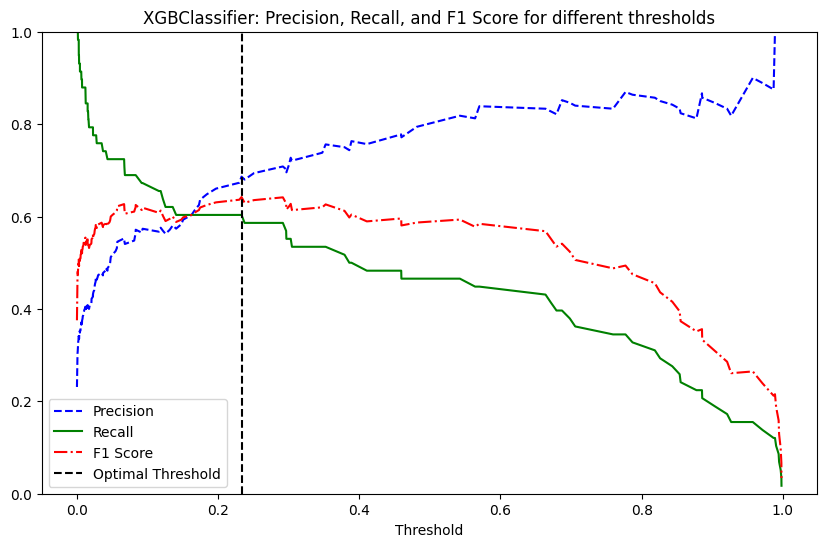

Optimal threshold for maximum XGBClassifier F1-score: 0.23315626
Using threshold ~0.2332 for evaluation.

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       208
           1       0.49      0.63      0.55        43

    accuracy                           0.82       251
   macro avg       0.70      0.75      0.72       251
weighted avg       0.85      0.82      0.83       251

XGBClassifier: F1 score 0.889991021399505


In [16]:
optimal_threshold_xgb, optimal_report_xgb = pr_threshold(xgb_model, model_name='XGBClassifier')

print("Optimal threshold for maximum XGBClassifier F1-score:", optimal_threshold_xgb)
print(f"Using threshold ~{optimal_threshold_xgb:.4f} for evaluation.\n")
print(optimal_report_xgb)

final_predictions_xgb = (xgb_model.predict(X_test) >= optimal_threshold_xgb).astype(int)
print("XGBClassifier: F1 score", f1_score(final_predictions_xgb, y_test, average="weighted"))

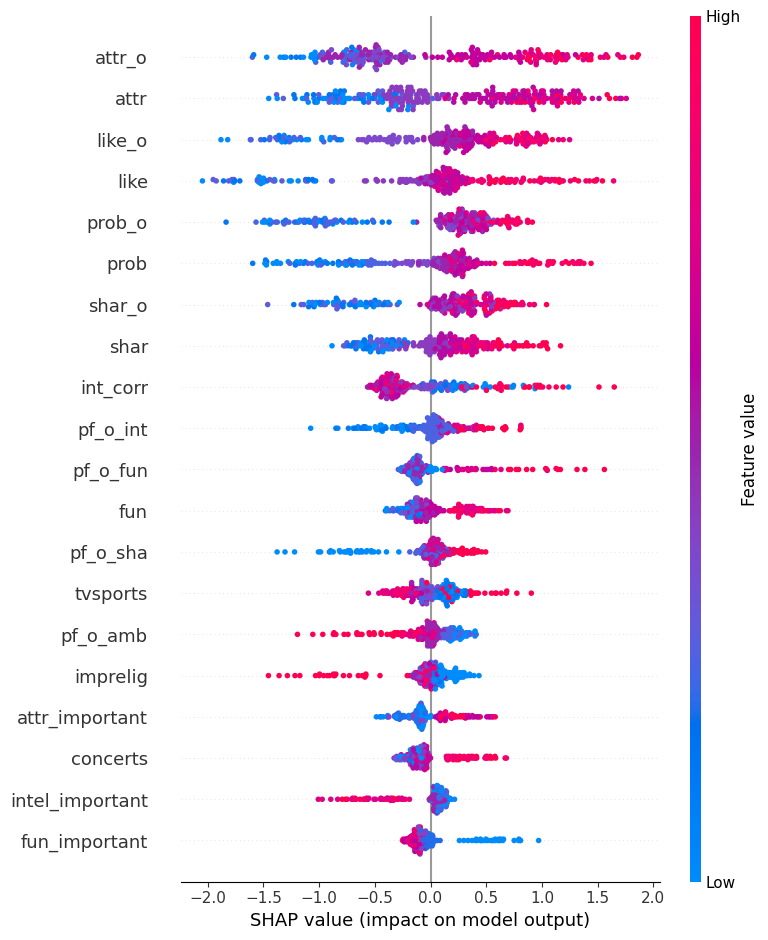

In [17]:
explainer = shap.Explainer(lgb_model, X_train)
shap_values_lgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_lgb, X_test)

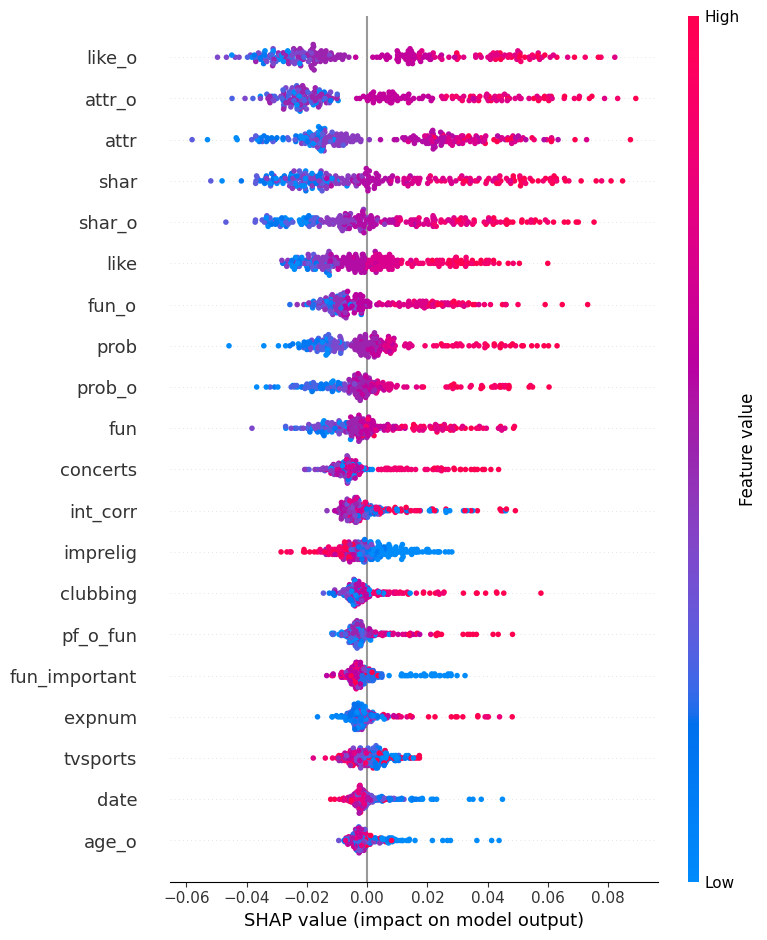

In [18]:
explainer = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer.shap_values(X_test, check_additivity=False)

# Visualize the SHAP values
shap.summary_plot(shap_values_rf[1], X_test)

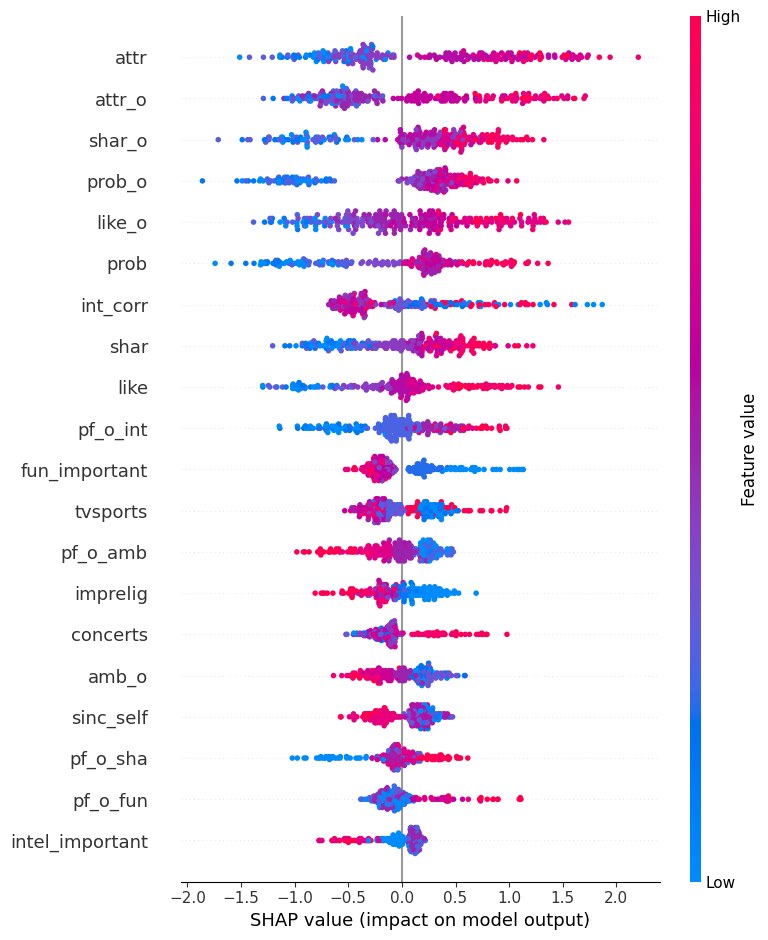

In [19]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_xgb, X_test)

In [20]:
def shap_importance(model, shap_values):
    """
    Return a dataframe containing the features sorted by Shap importance.

    Parameters:
    model : The tree-based model (like RandomForest, XGBoost, etc.).

    Returns:
    pd.DataFrame
        A dataframe containing the features sorted by Shap importance.
    """
    # explainer = shap.Explainer(model, X_train)
    
    # shap_values = explainer.shap_values(X_test, check_additivity=False)
    
    if isinstance(shap_values, list):
        shap_values = np.abs(shap_values[1])
    else:
        shap_values = np.abs(shap_values)
        
    mean_abs_shap_values = shap_values.mean(axis=0)
    
    feature_importance = pd.DataFrame({
        'features': X_test.columns,
        'importance': mean_abs_shap_values
    })
    
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    return feature_importance.reset_index(drop=True).head(30)

In [21]:
shap_importance(rf_model, shap_values_rf)

,features,importance
0,like_o,0.027732
1,attr_o,0.025604
2,attr,0.025145
3,shar,0.024328
4,shar_o,0.020584
5,like,0.015276
6,fun_o,0.013630
7,prob,0.013470
8,prob_o,0.011792
9,fun,0.011731


In [22]:
print(df_final['iid'].unique())

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37
  38  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 115 116 117 119 120 121 122 123 124 125 126 127 128 130 131]


In [24]:
df_final[df_final['wave'] == 1]
df_final.columns

Index(['iid', 'id', 'wave', 'partner', 'pid', 'match', 'int_corr', 'age_o',
       'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
       'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o',
       'like_o', 'prob_o', 'age', 'imprelig', 'goal', 'date', 'go_out',
       'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking',
       'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts',
       'music', 'shopping', 'yoga', 'exphappy', 'expnum', 'attr_important',
       'sinc_important', 'intel_important', 'fun_important', 'amb_important',
       'shar_important', 'attr_self', 'sinc_self', 'fun_self', 'intel_self',
       'amb_self', 'dec', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar',
       'like', 'prob'],
      dtype='object')

In [25]:
def wave_matches_display(df):
    # Dictionary to store data for each wave
    wave_data = {}

    # Group by wave and process each group
    for wave, group in df.groupby('wave'):
        # Collect all participants in the wave
        participants = list(group['iid'].unique())
        
        # Collect matches as lists of pairs
        matches = []
        for index, person in group.iterrows():
            if person['match'] == 1 and person['pid'] in group['iid'].values:
                matches.append([person['iid'], person['pid']])
        
        # Storing results in the dictionary with wave as key
        wave_data[wave] = {
            "participants": participants,
            "matches": matches
        }

    # Convert the dictionary into a DataFrame
    wave_df = pd.DataFrame([
        {'wave': wave, 'participants': data['participants'], 'matches': data['matches']}
        for wave, data in wave_data.items()
    ])

    return wave_df

wave_df = wave_matches_display(df_final)
wave_df_pred = wave_matches_display(df_pred)

In [26]:
wave_df

,wave,participants,matches
0,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]","[[1.0, 14.0], [1.0, 15.0], [1.0, 19.0], [2.0, 14.0], [2.0, 19.0], [4.0, 14.0], [4.0, 19.0], [5.0, 14.0], [5.0, 19.0], [6.0, 14.0], [6.0, 19.0], [7.0, 14.0], [7.0, 19.0], [8.0, 12.0], [8.0, 13.0], [8.0, 14.0], [8.0, 16.0], [8.0, 18.0], [8.0, 19.0], [8.0, 20.0], [9.0, 12.0], [9.0, 13.0], [9.0, 14.0], [9.0, 15.0], [9.0, 16.0], [9.0, 17.0], [9.0, 19.0], [10.0, 19.0], [12.0, 8.0], [12.0, 9.0], [13.0, 8.0], [13.0, 9.0], [14.0, 1.0], [14.0, 2.0], [14.0, 4.0], [14.0, 5.0], [14.0, 6.0], [14.0, 7.0], [14.0, 8.0], [14.0, 9.0], [15.0, 1.0], [15.0, 9.0], [16.0, 8.0], [16.0, 9.0], [17.0, 9.0], [18.0, 8.0], [19.0, 1.0], [19.0, 2.0], [19.0, 4.0], [19.0, 5.0], [19.0, 6.0], [19.0, 7.0], [19.0, 8.0], [19.0, 9.0], [19.0, 10.0], [20.0, 8.0]]"
1,2,"[21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]","[[22.0, 44.0], [22.0, 45.0], [23.0, 43.0], [23.0, 44.0], [23.0, 45.0], [27.0, 46.0], [29.0, 44.0], [29.0, 45.0], [30.0, 55.0], [31.0, 55.0], [34.0, 49.0], [35.0, 45.0], [35.0, 46.0], [35.0, 49.0], [35.0, 53.0], [36.0, 49.0], [36.0, 51.0], [37.0, 44.0], [37.0, 52.0], [38.0, 49.0], [38.0, 55.0], [39.0, 47.0], [43.0, 23.0], [44.0, 22.0], [44.0, 23.0], [44.0, 29.0], [44.0, 37.0], [45.0, 22.0], [45.0, 23.0], [45.0, 29.0], [45.0, 35.0], [46.0, 27.0], [46.0, 35.0], [47.0, 39.0], [49.0, 34.0], [49.0, 35.0], [49.0, 36.0], [49.0, 38.0], [51.0, 36.0], [52.0, 37.0], [53.0, 35.0], [55.0, 30.0], [55.0, 31.0], [55.0, 38.0]]"
2,3,"[56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]","[[56.0, 70.0], [57.0, 71.0], [61.0, 71.0], [61.0, 75.0], [62.0, 67.0], [62.0, 74.0], [63.0, 67.0], [64.0, 75.0], [67.0, 62.0], [67.0, 63.0], [70.0, 56.0], [71.0, 57.0], [71.0, 61.0], [74.0, 62.0], [75.0, 61.0], [75.0, 64.0]]"
3,4,"[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]","[[77.0, 94.0], [77.0, 97.0], [77.0, 99.0], [77.0, 105.0], [77.0, 107.0], [78.0, 107.0], [78.0, 109.0], [79.0, 107.0], [79.0, 108.0], [80.0, 102.0], [80.0, 105.0], [80.0, 109.0], [81.0, 99.0], [81.0, 104.0], [81.0, 108.0], [82.0, 94.0], [82.0, 99.0], [82.0, 105.0], [82.0, 107.0], [82.0, 109.0], [83.0, 99.0], [83.0, 107.0], [84.0, 105.0], [84.0, 108.0], [85.0, 107.0], [86.0, 97.0], [86.0, 100.0], [86.0, 104.0], [86.0, 105.0], [86.0, 107.0], [86.0, 108.0], [86.0, 109.0], [86.0, 110.0], [87.0, 99.0], [87.0, 107.0], [89.0, 99.0], [89.0, 104.0], [90.0, 109.0], [92.0, 97.0], [92.0, 99.0], [92.0, 105.0], [92.0, 107.0], [92.0, 109.0], [93.0, 95.0], [93.0, 100.0], [93.0, 104.0], [94.0, 77.0], [94.0, 82.0], [95.0, 93.0], [97.0, 77.0], [97.0, 86.0], [97.0, 92.0], [99.0, 77.0], [99.0, 81.0], [99.0, 82.0], [99.0, 83.0], [99.0, 87.0], [99.0, 89.0], [99.0, 92.0], [100.0, 86.0], [100.0, 93.0], [102.0, 80.0], [104.0, 81.0], [104.0, 86.0], [104.0, 89.0], [104.0, 93.0], [105.0, 77.0], [105.0, 80.0], [105.0, 82.0], [105.0, 84.0], [105.0, 86.0], [105.0, 92.0], [107.0, 77.0], [107.0, 78.0], [107.0, 79.0], [107.0, 82.0], [107.0, 83.0], [107.0, 85.0], [107.0, 86.0], [107.0, 87.0], [107.0, 92.0], [108.0, 79.0], [108.0, 81.0], [108.0, 84.0], [108.0, 86.0], [109.0, 78.0], [109.0, 80.0], [109.0, 82.0], [109.0, 86.0], [109.0, 90.0], [109.0, 92.0], [110.0, 86.0]]"
4,5,"[112, 113, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131]","[[112.0, 122.0], [112.0, 125.0], [112.0, 126.0], [112.0, 127.0], [112.0, 128.0], [113.0, 125.0], [113.0, 126.0], [113.0, 128.0], [115.0, 125.0], [115.0, 127.0], [115.0, 128.0], [116.0, 122.0], [116.0, 125.0], [116.0, 127.0], [117.0, 125.0], [119.0, 125.0], [119.0, 127.0], [120.0, 122.0], [120.0, 125.0], [120.0, 128.0], [122.0, 112.0], [122.0, 116.0], [122.0, 120.0], [125.0, 112.0], [125.0, 113.0], [125.0, 115.0], [125.0, 116.0], [125.0, 117.0], [125.0, 119.0], [125.0, 120.0], [126.0, 

In [27]:
#wave_df_pred

In [65]:
def indices_column(df, value):
    filtered_df = df[df['wave'] == value]
    indices = filtered_df.index.tolist()
    return indices

# select rows from another dataframe using the obtained indices
def select_rows(df, indices):
    return df.iloc[indices]

indices = indices_column(df_final, 1)
df_wave_6 = select_rows(df_final, indices)
df_wave_6 = df_wave_6.drop(columns=['id', 'partner', 'wave', 'age_o', 'expnum'], axis=1)
#df_wave_6 = df_wave_6.fillna(0)
print(indices)

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 143, 144, 145, 146, 148, 150, 151, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


In [47]:
attributes = [
    'iid', 
    'attr_o', 
    'sinc_o',
    'intel_o', 
    'fun_o', 
    'amb_o', 
    'shar_o',    
    # 'attr_self', 
    # 'sinc_self', 
    # 'intel_self', 
    # 'fun_self', 
    # 'amb_self'
]

attributes_averages = df_wave_6[attributes].groupby('iid').mean().reset_index()
print(attributes_averages)

    iid    attr_o    sinc_o   intel_o     fun_o     amb_o    shar_o
0     1  6.250000  7.000000  7.625000  6.750000  7.625000  6.625000
1     2  7.700000  7.100000  7.900000  7.500000  7.500000  6.500000
2     3  6.833333  7.166667  7.833333  6.333333  7.500000  6.166667
3     4  7.000000  7.100000  7.700000  7.500000  7.700000  7.200000
4     5  5.300000  7.700000  7.600000  7.200000  7.800000  6.200000
5     6  6.800000  7.800000  8.600000  7.000000  8.000000  6.300000
6     7  7.900000  7.600000  8.200000  7.000000  7.500000  6.700000
7     8  8.125000  7.750000  8.125000  7.500000  7.375000  6.375000
8     9  7.000000  7.400000  7.500000  7.800000  6.900000  6.300000
9    10  6.500000  6.500000  6.500000  6.500000  6.000000  6.000000
10   11  5.500000  8.000000  7.500000  5.500000  6.000000  4.000000
11   12  7.875000  7.125000  7.875000  7.250000  7.875000  6.125000
12   13  4.714286  7.857143  8.714286  6.285714  6.000000  5.857143
13   14  8.142857  7.428571  7.000000  7.285714 

In [60]:
def compute_importance_scores(averages, importance):
    scores = averages.copy()
    for attribute in importance.columns:
        if attribute in scores.columns:
            scores[attribute] *= importance[attribute]
    scores['total_score'] = scores.sum(axis=1)
    return scores.reset_index(drop=True)

importance = df_wave_6[[
    'attr_important', 
    'sinc_important', 
    'intel_important',
    'fun_important', 
    'amb_important', 
    'shar_important'
]]

importance_attributes = compute_importance_scores(attributes_averages, importance)
importance_attributes.columns

Index(['iid', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o',
       'total_score'],
      dtype='object')

This will all be put into a *Class* later to make it look prettier 

In [62]:
def compute_scores(averages, importance):
    """
    Computes and ranks potential partners for each individual based on their preference weights.
    """
    results = {}
    for index, person in importance.iterrows():
        # Calculate a weighted score for every other person
        person_scores = averages.copy()
        for attribute in importance.columns:
            if attribute in averages.columns:
                person_scores[attribute] *= person.loc[attribute]
        person_scores['total_score'] = person_scores.sum(axis=1)
            
        # Exclude the person themselves and rank others based on total_score
        person_scores = person_scores[person_scores['iid'] != person['iid']]
        person_scores.sort_values('total_score', ascending=False, inplace=True)
        results[person['iid']] = person_scores[['iid', 'total_score']]
        
    return results

compute_scores(attributes_averages, importance_attributes)

{1.0:      iid  total_score
 19  20.0   341.000000
 18  19.0   330.916667
 7    8.0   324.078125
 6    7.0   320.925000
 13  14.0   320.803571
 11  12.0   320.703125
 5    6.0   318.662500
 16  17.0   316.232143
 3    4.0   313.200000
 1    2.0   310.937500
 8    9.0   308.737500
 4    5.0   299.125000
 2    3.0   296.395833
 17  18.0   292.291667
 12  13.0   290.892857
 14  15.0   288.312500
 20  21.0   287.038462
 9   10.0   275.062500
 10  11.0   267.937500
 15  16.0   260.843750
 21  22.0   249.537500,
 2.0:      iid  total_score
 19  40.0   378.655556
 18  38.0   367.988889
 13  28.0   352.957143
 7   16.0   350.775000
 11  24.0   350.687500
 16  34.0   349.614286
 6   14.0   345.870000
 5   12.0   341.130000
 8   18.0   334.890000
 3    8.0   333.940000
 1    4.0   330.860000
 17  36.0   322.883333
 20  42.0   321.030769
 4   10.0   318.320000
 14  30.0   317.433333
 12  26.0   317.142857
 2    6.0   315.216667
 9   20.0   300.300000
 10  22.0   292.650000
 15  32.0   289.375000


In [30]:
def cosine_pairs_similarity(df, pairs, features):
    """
    Calculate cosine similarity for specified pairs in the DataFrame.

    Args:
    - df (DataFrame): The DataFrame containing user features.
    - pairs (list of lists): A list containing sublists, each sublist is a pair of IDs [iid, pid].
    - features (list): A list of column names to use as features for calculating similarity.

    Returns:
    - DataFrame: A DataFrame with the pair identifiers and their similarity scores.
    """
    results = []

    # Standardize the features
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    # Process each pair
    for pair in pairs:
        id1, id2 = pair
        # Extract features for both ids in the pair
        person1_features = df.loc[df['iid'] == id1, features].values
        person2_features = df.loc[df['iid'] == id2, features].values

        # Calculate cosine similarity
        if len(person1_features) > 0 and len(person2_features) > 0:  # Ensure both persons are in the dataset
            similarity_score = cosine_similarity(person1_features, person2_features)[0][0]
            results.append([id1, id2, similarity_score])

    # Convert results to DataFrame
    similarity_df = pd.DataFrame(results, columns=['iid', 'pid', 'similarity_score'])

    return similarity_df

features = ['int_corr', 'pf_o_att', 'pf_o_sin', 'pf_o_int',
       'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o',
       'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'age',
       'imprelig', 'goal', 'date', 'go_out', 'sports', 'tvsports', 'exercise',
       'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading',
       'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'exphappy', 'attr_important', 'sinc_important', 'intel_important',
       'fun_important', 'amb_important', 'shar_important', 'attr_self',
       'sinc_self', 'fun_self', 'intel_self', 'amb_self', 'dec', 'attr',
       'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob']
pairs = [[1.0, 14.0], [1.0, 15.0], [1.0, 19.0], [2.0, 14.0], [2.0, 19.0], [4.0, 14.0], [4.0, 19.0], [5.0, 14.0], [5.0, 19.0], [6.0, 14.0], [6.0, 19.0], [7.0, 14.0], [7.0, 19.0], [8.0, 12.0], [8.0, 13.0], [8.0, 14.0], [8.0, 16.0], [8.0, 18.0], [8.0, 19.0], [8.0, 20.0], [9.0, 12.0], [9.0, 13.0], [9.0, 14.0], [9.0, 15.0], [9.0, 16.0], [9.0, 17.0], [9.0, 19.0], [10.0, 19.0], [12.0, 8.0], [12.0, 9.0], [13.0, 8.0], [13.0, 9.0], [14.0, 1.0], [14.0, 2.0], [14.0, 4.0], [14.0, 5.0], [14.0, 6.0], [14.0, 7.0], [14.0, 8.0], [14.0, 9.0], [15.0, 1.0], [15.0, 9.0], [16.0, 8.0], [16.0, 9.0], [17.0, 9.0], [18.0, 8.0], [19.0, 1.0], [19.0, 2.0], [19.0, 4.0], [19.0, 5.0], [19.0, 6.0], [19.0, 7.0], [19.0, 8.0], [19.0, 9.0], [19.0, 10.0], [20.0, 8.0]]
similarity_results = cosine_pairs_similarity(df_wave_6, pairs, features)
print(similarity_results)

     iid   pid  similarity_score
0    1.0  14.0          0.126051
1    1.0  15.0         -0.086037
2    1.0  19.0         -0.215220
3    2.0  14.0         -0.353812
4    2.0  19.0         -0.124475
5    4.0  14.0         -0.111827
6    4.0  19.0         -0.335717
7    5.0  14.0         -0.194040
8    5.0  19.0         -0.144448
9    6.0  14.0         -0.099550
10   6.0  19.0         -0.026725
11   7.0  14.0         -0.217139
12   7.0  19.0         -0.261474
13   8.0  12.0         -0.162304
14   8.0  13.0         -0.084349
15   8.0  14.0         -0.391682
16   8.0  16.0         -0.110162
17   8.0  18.0         -0.175937
18   8.0  19.0         -0.229678
19   8.0  20.0          0.078574
20   9.0  12.0         -0.087037
21   9.0  13.0          0.241444
22   9.0  14.0         -0.054320
23   9.0  15.0         -0.064890
24   9.0  16.0          0.121692
25   9.0  17.0         -0.261797
26   9.0  19.0         -0.167705
27  10.0  19.0          0.171112
28  12.0   8.0         -0.162304
29  12.0  